In [1]:
import brambox as bb
import lightnet as ln
import pandas as pd
import dataset
import utils
import numpy as np
import glob
import ptflops
import cv2
import os
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt

# Annotations

In [192]:
def parse_annos(list_file):
    anno = dataset.parse_annos(list_file, '../data/video', 15)
    anno = bb.util.concat(anno)
    anno['image'] = anno.image.cat.rename_categories([os.path.join(*cat.split(os.sep)[-3:]) for cat in anno.image.cat.categories])
    return anno

anno_90 = parse_annos('../data/video/meta_test/all_90.txt')
display(anno_90.head())

anno_45 = parse_annos('../data/video/meta_test/all_45.txt')
display(anno_45.head())

INFO         Parsing annotations
100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


image class_label   id  x_top_left  y_top_left  width  \
0  clip000/img/image0000159      person  0.0       29.40       10.90   2.60   
1  clip000/img/image0000160      person  0.0       28.65       10.57   3.35   
2  clip000/img/image0000161      person  0.0       27.90       10.23   4.10   
3  clip000/img/image0000162      person  0.0       27.15        9.90   4.85   
4  clip000/img/image0000163      person  0.0       26.40        9.57   5.60   

   height  occluded  truncated   lost  difficult  ignore  
0    4.10       0.0        0.0  False      False    True  
1    4.73       0.0        0.0  False      False   False  
2    5.37       0.0        0.0  False      False   False  
3    6.00       0.0        0.0  False      False   False  
4    6.63       0.0        0.0  False      False   False

INFO         Parsing annotations
100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


image class_label   id  x_top_left  y_top_left  width  \
0  clip003/img/image0000109      person  0.0        26.8        21.1    5.2   
1  clip003/img/image0000110      person  0.0        26.2        20.9    5.7   
2  clip003/img/image0000111      person  0.0        25.6        16.9    6.2   
3  clip003/img/image0000112      person  0.0        23.5        14.8    8.6   
4  clip003/img/image0000113      person  0.0        23.2        14.1    8.7   

   height  occluded  truncated   lost  difficult  ignore  
0     2.7       0.0        0.0  False      False    True  
1     3.0       0.0        0.0  False      False   False  
2     7.1       0.0        0.0  False      False   False  
3     8.0       0.0        0.0  False      False   False  
4     8.8       0.0        0.0  False      False   False

In [193]:
# Matching criteria
match_criteria_thresh = 0.5
match_criteria = bb.stat.coordinates.ioa
#match_criteria = bb.stat.coordinates.iou

# Added value of background subtraction

TODO: re-run models with background subtraction with our background generator

## Detections

In [205]:
# TODO rerun bg sub models with background builder
det_90_ours = OrderedDict([
    ('reference', 'detections/set16_top_maarten-denayer_September13_23_57_58_microyolo_4.parquet'),
    ('frame diff', 'detections/set16_top_maarten-denayer_September14_05_29_51_microyolo_5.parquet'),
    ('bg sub (ours)', 'detections/set16_top_maarten-denayer_August31_18_20_37_microyolo.parquet'),
    ('bg sub + frame diff', 'detections/set16_top_maarten-denayer_September06_18_07_26_microyolo_2.parquet'),
])

det_all_ours = OrderedDict([
    ('reference', 'detections/set05_maarten-denayer_September10_03_43_59_microyolo_all_1.parquet'),
    ('frame diff', 'detections/set05_maarten-denayer_September13_21_11_49_microyolo_all_4.parquet'),
    ('bg sub (ours)', 'detections/set05_maarten-denayer_September10_08_31_18_microyolo_all_2.parquet'),
    ('bg sub + frame diff', 'detections/set05_maarten-denayer_September09_18_26_13_microyolo_all_3.parquet'),
])

#det_45_ours = OrderedDict([
#    ('baseline', 'detections/set05_maarten-denayer_September09_00_52_11_microyolo_45_1.parquet'),
#    ('frame diff', 'detections/set05_maarten-denayer_September14_05_52_18_microyolo_45_4.parquet'),
#    ('bg sub (ours)', 'detections/set05_maarten-denayer_September09_03_40_22_microyolo_45_2.parquet'),
#    ('bg sub + frame diff', 'detections/set05_maarten-denayer_September09_18_21_38_microyolo_45_3.parquet')
#])

reference: threshold = 0.20724835991859436
frame diff: threshold = 0.2550857365131378
bg sub (ours): threshold = 0.39087703824043274
bg sub + frame diff: threshold = 0.38763919472694397


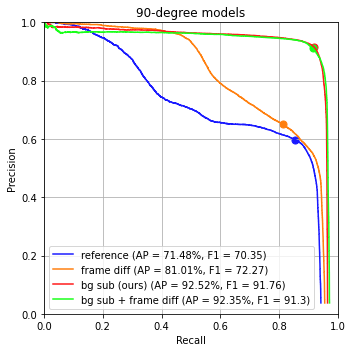

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


reference: threshold = 0.32762089371681213
frame diff: threshold = 0.2967580556869507
bg sub (ours): threshold = 0.38407546281814575
bg sub + frame diff: threshold = 0.3645608425140381


<Figure size 432x288 with 0 Axes>

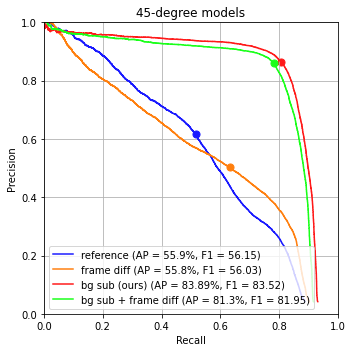

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

In [215]:
def calc_pr_ap_f1(anno, det_file):
    # read detections and rename categories to match the annotations
    det = pd.read_parquet(det_file)
    det['image'] = det.image.cat.rename_categories([os.path.join(*cat.split(os.sep)[-3:]) for cat in det.image.cat.categories])

    # Compute TP,FP
    tpfp_det = bb.stat.match_det(det, anno, match_criteria_thresh, criteria=match_criteria)

    # calculate PR-curve
    pr = bb.stat.pr(tpfp_det, anno, match_criteria_thresh)
    ap = bb.stat.ap(pr)
    
    # calculate optimal F1
    f1 = bb.stat.fscore(pr)
    threshold = bb.stat.peak(f1)
    
    return pr, ap, f1, threshold
    
def plot_pr(det_data, anno, title):
    ax = None
    colors = ['#1919ff', '#ff7f0e', '#ff1919', '#19ff19', '#19ff19']
    for i, (label, det_file) in enumerate(det_data.items()):
        if not det_file:
            continue

        color = colors[i]
        pr, ap, f1, thresh = calc_pr_ap_f1(anno, det_file)
        print(f"{label}: threshold =", thresh.confidence)
        label = f'{label} (AP = {round(100*ap, 2)}%, F1 = {round(100*thresh.f1, 2)})'
        ax = pr.plot('recall', 'precision', ax=ax, label=label, figsize=(5, 5), color=color)
        pr_point = bb.stat.point(pr, thresh.confidence)
        plt.scatter(pr_point.recall, pr_point.precision, s=50, color=color)
        
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    plt.grid()
    plt.legend(loc=3)
    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(title.replace(' ', '_') + '.eps', format='eps', dpi=1200)
    
plot_pr(det_90_ours, anno_90, '90-degree models')
plot_pr(det_all_ours, anno_45, '45-degree models')
#plot_pr(det_45_ours, anno_45, '45-degree models')

# Compression

In [207]:
def calc_stats(params):
    h, w = params.input_dimension
    macs, num_params = ptflops.get_model_complexity_info(params.network, (params.network.input_channels, h, w), as_strings=False,
                                                         print_per_layer_stat=False, verbose=False)
    macs_str = ptflops.flops_counter.flops_to_string(macs, units='MMac')
    num_params_str = ptflops.flops_counter.params_to_string(num_params)

    return macs, num_params, macs_str, num_params_str

def get_weights_and_cfg_filenames(model_detections_filename):
    weights_file = os.path.splitext(os.path.basename(model_detections_filename))[0]
    weights_file = weights_file.replace('_maarten', os.sep + 'maarten')
    if 'pruned' in weights_file:
        weights_file = weights_file.replace('_pruned', os.sep + 'checkpoints' + os.sep + 'pruned') + '.pt'
    else:
        weights_file = os.path.join(weights_file, 'checkpoints', 'best.pt')
        
    if 'quant' in weights_file:
        weights_file = weights_file.replace('_quant.pt', '.pt')
    
    weights_file = os.path.join('..', 'logs', weights_file)
    log_folder = os.path.join(*weights_file.split(os.sep)[:-2])
    cfg_file = glob.glob(os.path.join(log_folder, '*.py'))[0]
    
    print(cfg_file, weights_file)
    return cfg_file, weights_file
    
def get_stats(model_detections_filename):
    """Get model size and MACS of unpruned model"""
    cfg_file, weights_file = get_weights_and_cfg_filenames(model_detections_filename)
    
    # load network parameters
    params = ln.engine.HyperParameters.from_file(cfg_file)
    macs_orig, num_params_orig, macs_str, num_params_str = calc_stats(params)
    return macs_str, num_params_str

def get_stats_pruned(model_detections_filename):
    """Get model size and MACS of pruned model"""
    cfg_file, weights_file = get_weights_and_cfg_filenames(model_detections_filename)
    
    # load network parameters and pruned weights
    params = ln.engine.HyperParameters.from_file(cfg_file)
    params.network.load_pruned(weights_file)
    
    macs_orig, num_params_orig, macs_str, num_params_str = calc_stats(params)
    return macs_str, num_params_str

def create_compression_results_table(det_compression, anno):
    """Return AP, model size, and model MACS"""
    compress_results = {'name':[], 'AP':[], 'F1':[], 'size':[], 'MACS':[]}
    
    for name, det_file in det_compression.items():
        pr, ap, f1, thresh = calc_pr_ap_f1(anno, det_file)
        if 'pruned' in det_file:
            macs, num_params = get_stats_pruned(det_file)
        else:
            macs, num_params = get_stats(det_file)
        compress_results['name'].append(name)
        compress_results['AP'].append(f'{round(100 * ap, 2)}')
        compress_results['F1'].append(f'{round(100 * thresh.f1, 2)}')
        compress_results['size'].append(num_params)
        compress_results['MACS'].append(macs)
        
    return pd.DataFrame.from_dict(compress_results)
    
det_90_compression = OrderedDict([
    ('original', 'detections/set16_top_maarten-denayer_August31_18_20_37_microyolo.parquet'),
    ('pruned-49', 'detections/set06_prune_maarten-denayer_September17_20_48_43_microyolo_l2_prune_90_pruned-49.parquet'),
    ('pruned-49-quant', 'detections/set06_prune_maarten-denayer_September17_20_48_43_microyolo_l2_prune_90_pruned-49_quant.parquet'),
])

det_45_compression = OrderedDict([
    ('original', 'detections/set05_maarten-denayer_September10_08_31_18_microyolo_all_2.parquet'),
    ('pruned-44', 'detections/set06_prune_maarten-denayer_September19_11_21_11_microyolo_l2_prune_pruned-44.parquet'),
    ('pruned-44-quant', 'detections/set06_prune_maarten-denayer_September19_11_21_11_microyolo_l2_prune_pruned-44_quant.parquet'),
])

res_90 = create_compression_results_table(det_90_compression, anno_90)
res_45 = create_compression_results_table(det_45_compression, anno_45)
display(res_90)
display(res_45)

../logs/set16_top/maarten-denayer_August31_18_20_37_microyolo/microyolo.py ../logs/set16_top/maarten-denayer_August31_18_20_37_microyolo/checkpoints/best.pt
Feature channels 512
../logs/set06_prune/maarten-denayer_September17_20_48_43_microyolo_l2_prune_90/microyolo_l2_prune_90.py ../logs/set06_prune/maarten-denayer_September17_20_48_43_microyolo_l2_prune_90/checkpoints/pruned-49.pt
Feature channels 512


/home/maarten/.virtualenvs/p36_tinyml_object_detection/lib/python3.6/site-packages/torch/onnx/utils.py:258: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
INFO         Cannot prune [features.0.layers.0], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.1.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.1.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.2.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.2.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.3.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Canno

../logs/set06_prune/maarten-denayer_September17_20_48_43_microyolo_l2_prune_90/microyolo_l2_prune_90.py ../logs/set06_prune/maarten-denayer_September17_20_48_43_microyolo_l2_prune_90/checkpoints/pruned-49.pt
Feature channels 512


INFO         Cannot prune [features.0.layers.0], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.1.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.1.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.2.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.2.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.3.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.3.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.4.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.4.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.5.layers.0], unimplemented dependency [AT

../logs/set05/maarten-denayer_September10_08_31_18_microyolo_all_2/microyolo_all_2.py ../logs/set05/maarten-denayer_September10_08_31_18_microyolo_all_2/checkpoints/best.pt
Feature channels 512
../logs/set06_prune/maarten-denayer_September19_11_21_11_microyolo_l2_prune/microyolo_l2_prune.py ../logs/set06_prune/maarten-denayer_September19_11_21_11_microyolo_l2_prune/checkpoints/pruned-44.pt
Feature channels 512


INFO         Cannot prune [features.0.layers.0], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.1.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.1.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.2.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.2.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.3.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.3.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.4.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.4.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.5.layers.0], unimplemented dependency [AT

../logs/set06_prune/maarten-denayer_September19_11_21_11_microyolo_l2_prune/microyolo_l2_prune.py ../logs/set06_prune/maarten-denayer_September19_11_21_11_microyolo_l2_prune/checkpoints/pruned-44.pt
Feature channels 512


INFO         Cannot prune [features.0.layers.0], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.1.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.1.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.2.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.2.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.3.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.3.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.4.layers.0], unimplemented dependency [ATen: Grouped Convolution (cannot prune)]
INFO         Cannot prune [features.4.layers.3], unimplemented dependency [ATen: hardtanh]
INFO         Cannot prune [features.5.layers.0], unimplemented dependency [AT

name     AP     F1    size        MACS
0         original  92.52  91.76  1.26 M  68.36 MMac
1        pruned-49  92.49  91.75  9.23 k   1.32 MMac
2  pruned-49-quant  92.29  91.62  9.23 k   1.32 MMac

name     AP     F1     size        MACS
0         original  83.89  83.52   1.26 M  68.36 MMac
1        pruned-44  80.48   80.5  13.86 k   1.95 MMac
2  pruned-44-quant  79.47   79.9  13.86 k   1.95 MMac

# Deployment results

## Inference times

/home/maarten/.virtualenvs/p36_tinyml_object_detection/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


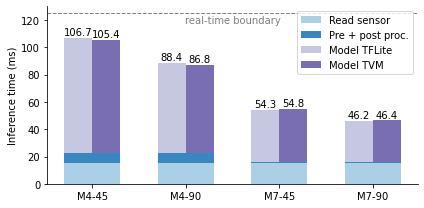

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [91]:
import seaborn as sns

colors = sns.color_palette("Purples", 2)
colors2 = sns.color_palette("Blues", 2)

# sums here are from left to right: temp calculation + input norm + yolo post process + background sub
prepost_times_m7 = 0.85+0.14+0.25+0.01
prepost_times_m4 = 6.85+0.18+0.47+0.01

labels          = ['M4-45', 'M4-90', 'M7-45', 'M7-90']
tflite_times    = np.array([84.2,    65.9,    38.08,   30.0])
tvm_times       = np.array([82.9,    64.3,    38.5,    30.18])

# fixed number for both devices, since this is only dependent on the I2C clock frequency (1MHz)
image_acq_times = np.array(4*[15.0])

prepost_times   = np.array([prepost_times_m4, prepost_times_m4, prepost_times_m7, prepost_times_m7])

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

def addlabels(x,y, offset):
    for i in range(len(x)):
        plt.text(i+offset, y[i]+2, round(y[i], 1), ha = 'center')
        
fig, ax = plt.subplots(figsize=(6, 3))

ax.bar(x, image_acq_times, 2*width, label='Read sensor', color=colors2[0])
ax.bar(x, prepost_times, 2*width, bottom=image_acq_times, label='Pre + post proc.', color=colors2[1])

ax.bar(x - width/2, tflite_times, width, bottom=image_acq_times+prepost_times, label='Model TFLite', color=colors[0])
addlabels(x, image_acq_times+prepost_times+tflite_times, -width/2)

ax.bar(x + width/2, tvm_times, width, bottom=image_acq_times+prepost_times, label='Model TVM', color=colors[1])
addlabels(x, image_acq_times+prepost_times+tvm_times, width/2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference time (ms)')
#ax.set_title('Inference times')
ax.set_xticks(x, labels)
ax.legend()

# real-time boundary
ax.set_ylim([0, 130])
plt.axhline(y=125, color='gray', linewidth=1, linestyle='--')
plt.text(1.5, 118, "real-time boundary", ha='center', color='gray')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set bar labels
plt.xticks(x, labels)

fig.tight_layout()
plt.show()
fig.savefig('infer_times.eps', format='eps', dpi=1200)

## Ram usage

/home/maarten/.virtualenvs/p36_tinyml_object_detection/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


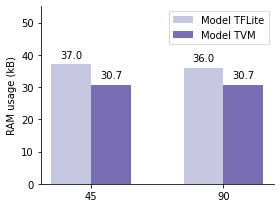

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [89]:
colors = sns.color_palette("Purples", 2)

labels =       ['45',      '90']
ram_tflite =   [37.0,       36.0]
ram_tvm =      [28.7+1.968, 28.7+1.968]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

def addlabels(x,y, offset):
    for i in range(len(x)):
        plt.text(i+offset, y[i]+2, round(y[i], 1), ha = 'center')
        
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, ram_tflite, width, label='Model TFLite', color=colors[0])
addlabels(x, ram_tflite, -width/2)

ax.bar(x + width/2, ram_tvm, width, label='Model TVM', color=colors[1])
addlabels(x, ram_tvm, width/2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RAM usage (kB)')
ax.set_xticks(x, labels)
ax.legend()

# real-time boundary
ax.set_ylim([0, 55])

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set bar labels
plt.xticks(x, labels)

fig.tight_layout()
plt.show()
fig.savefig('ram_usage.eps', format='eps', dpi=1200)

## Flash usage

/home/maarten/.virtualenvs/p36_tinyml_object_detection/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


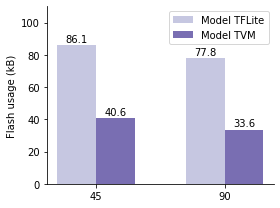

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [90]:
colors = sns.color_palette("Purples", 2)

labels =       ['45',      '90']
flash_tflite = [44.1+42.0,  35.8+42.0]
flash_tvm =    [29.4+11.2,  22.41+11.2]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

def addlabels(x,y, offset):
    for i in range(len(x)):
        plt.text(i+offset, y[i]+2, round(y[i], 1), ha = 'center')
        
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, flash_tflite, width, label='Model TFLite', color=colors[0])
addlabels(x, flash_tflite, -width/2)

ax.bar(x + width/2, flash_tvm, width, label='Model TVM', color=colors[1])
addlabels(x, flash_tvm, width/2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Flash usage (kB)')
ax.set_xticks(x, labels)
ax.legend()

# real-time boundary
ax.set_ylim([0, 110])

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set bar labels
plt.xticks(x, labels)

fig.tight_layout()
plt.show()
fig.savefig('flash_usage.eps', format='eps', dpi=1200)